In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy.table import Table
#from astropy import wcs
from astropy.stats import sigma_clipped_stats
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
#import pandas as pd
#from ipywidgets import FloatProgress
from IPython.display import display
from MUSE_Models import MUSE_1D_residual, data_cube_y_x
import sep
from photutils import CircularAperture, find_peaks

%config InlineBackend.figure_format = 'retina'

In [ ]:
# x,y = (213, 142)

In [2]:
lnl_cube = fits.open("FCC167_data/FCC167_lnl_cube.fits")
Gandalf_fit = fits.open("FCC167_data/FCC167_GandALF_fit-004.fits")
Gandalf_fit_emission = fits.open("FCC167_data/FCC167_GandALF_fit_emission-002.fits")
#ppxf_fit = fits.open("FCC255_data/FCC255_pPXF_fit-004.fits")

Gandalf_stellar = Gandalf_fit[0].data - Gandalf_fit_emission[0].data
emission_cube = lnl_cube[0].data - Gandalf_stellar
hdu = fits.PrimaryHDU(emission_cube)
hdu.writeto("FCC167_data/FCC167_emission_cube.fits")

In [7]:
hdulist = fits.open("FCC167_data/FCC167_emission_cube.fits")
raw_data = hdulist[0].data
hdr = hdulist[0].header

In [13]:
wavelength = np.exp(lnl_cube[1].data)
np.save("FCC167_data/FCC167_wavelength", wavelength)

In [3]:
# Open Fits file and assign to raw_data
hdulist = fits.open("FCC167_data/FCC167_emission_cube.fits")
#raw_data = hdulist[0].data
#hdr = hdulist[0].header

y_data, x_data, n_data = data_cube_y_x(len(hdulist[0].data))
#y_data = hdr["NAXIS2"]
#x_data = hdr["NAXIS1"]

wavelength = np.load("FCC167_data/FCC167_wavelength.npy")#np.exp(hdulist[1].data)
#hdr['CRVAL3']+np.arange(hdr["NAXIS3"])*hdr['CDELT3']

#np.save("exported_data/FCC167/wavelength", wavelength)
#y_data = hdr["NAXIS2"]
#x_data = hdr["NAXIS1"]

coordinates = [(n,m) for n in range(x_data) for m in range(y_data)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

#oo = np.loadtxt('FCC167_data/FCC167_xy_ima_yngoodspaxels.txt', skiprows=1)
#fit_these = oo[:,2]

#raw_data_list_fitted = np.squeeze(np.where(fit_these == 1))

#raw_data_list_for_fit = raw_data_list[raw_data_list_fitted]

non_zero_index = np.squeeze(np.where(hdulist[0].data[:,0] != 0.))

list_of_std = np.abs(np.std(hdulist[0].data ,1))
input_errors = [np.repeat(item, len(wavelength)) for item in list_of_std]

# 1D fit function

In [4]:
def Gaussian_1D_res(params, x, data, error, spec_num):
    Amp = params["Amp"]
    mean = params["mean"]
    FWHM = params["FWHM"]
    Gauss_bkg = params["Gauss_bkg"]
    Gauss_grad = params["Gauss_grad"]

    Gauss_std = FWHM / 2.35482
    model = ((Gauss_bkg + Gauss_grad * x) + Amp * np.exp(- 0.5 * (x - mean)** 2 / Gauss_std**2.) +
             (Amp/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / Gauss_std**2.))

    list_of_rN[spec_num] = np.std(data - model)
    list_of_residuals[spec_num] = data - model

    return (data - model) / error

params = Parameters()
params.add("Amp",value=70., min=0.001)
params.add("mean", value=5038., min=5000., max=5080.)
params.add("FWHM", value=2.81, vary=False) # LSF
params.add("Gauss_bkg", value=0.001)#, min=-500., max=500.)
params.add("Gauss_grad", value=0.001)

list_of_rN = np.zeros(len(hdulist[0].data))
list_of_residuals = np.zeros((len(hdulist[0].data),len(wavelength)))
list_of_residuals_from_fitter = np.zeros((len(hdulist[0].data),len(wavelength)))
best_fit_A = np.zeros((len(hdulist[0].data),2))
#best_fit_mean = np.zeros((len(raw_data_list),2))

In [5]:
for n in non_zero_index:
    results = minimize(Gaussian_1D_res, params, args=(wavelength, hdulist[0].data[n], input_errors[n], n), nan_policy="propagate")
    best_fit_A[n] = [results.params["Amp"], results.params["Amp"].stderr]
    #best_fit_mean[spec_n] = [results.params["mean"], results.params["mean"].stderr]
    list_of_residuals_from_fitter[n] = results.residual

In [6]:
gauss_A = [A[0] for A in best_fit_A]
A_err = [A[1] for A in best_fit_A]

A_rN = np.array([A / rN for A,rN in zip(gauss_A, list_of_rN)])
A_rN_shape = A_rN.reshape(y_data,x_data)

Gauss_F = np.array(gauss_A) * np.sqrt(2*np.pi) * 1.19
Gauss_F_shape = Gauss_F.reshape(y_data, x_data)

/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [8]:
np.save("exported_data/FCC167/A_rN_cen", A_rN)
np.save("exported_data/FCC167/gauss_A_cen", gauss_A)
np.save("exported_data/FCC167/gauss_A_err_cen", A_err)
np.save("exported_data/FCC167/gauss_F_cen", Gauss_F)
np.save("exported_data/FCC167/resids_data", list_of_residuals)
np.save("exported_data/FCC167/resids_obj", list_of_residuals_from_fitter)
np.save("exported_data/FCC167/rN", list_of_rN)

In [17]:
A_rN = np.load("exported_data/FCC167/A_rN_cen.npy")
gauss_A = np.load("exported_data/FCC167/gauss_A_cen.npy")
Gauss_F = np.load("exported_data/FCC167/gauss_F_cen.npy")
#rN = np.load("exported_data/FCC167/rN.npy")

#rN_shape = np.abs(rN).reshape(y_data, x_data)
gauss_A_shape = gauss_A.reshape(y_data, x_data)
A_rN_shape = A_rN.reshape(y_data,x_data)
Gauss_F_shape = Gauss_F.reshape(y_data, x_data)

In [75]:
list_of_rN[-2]

0.0

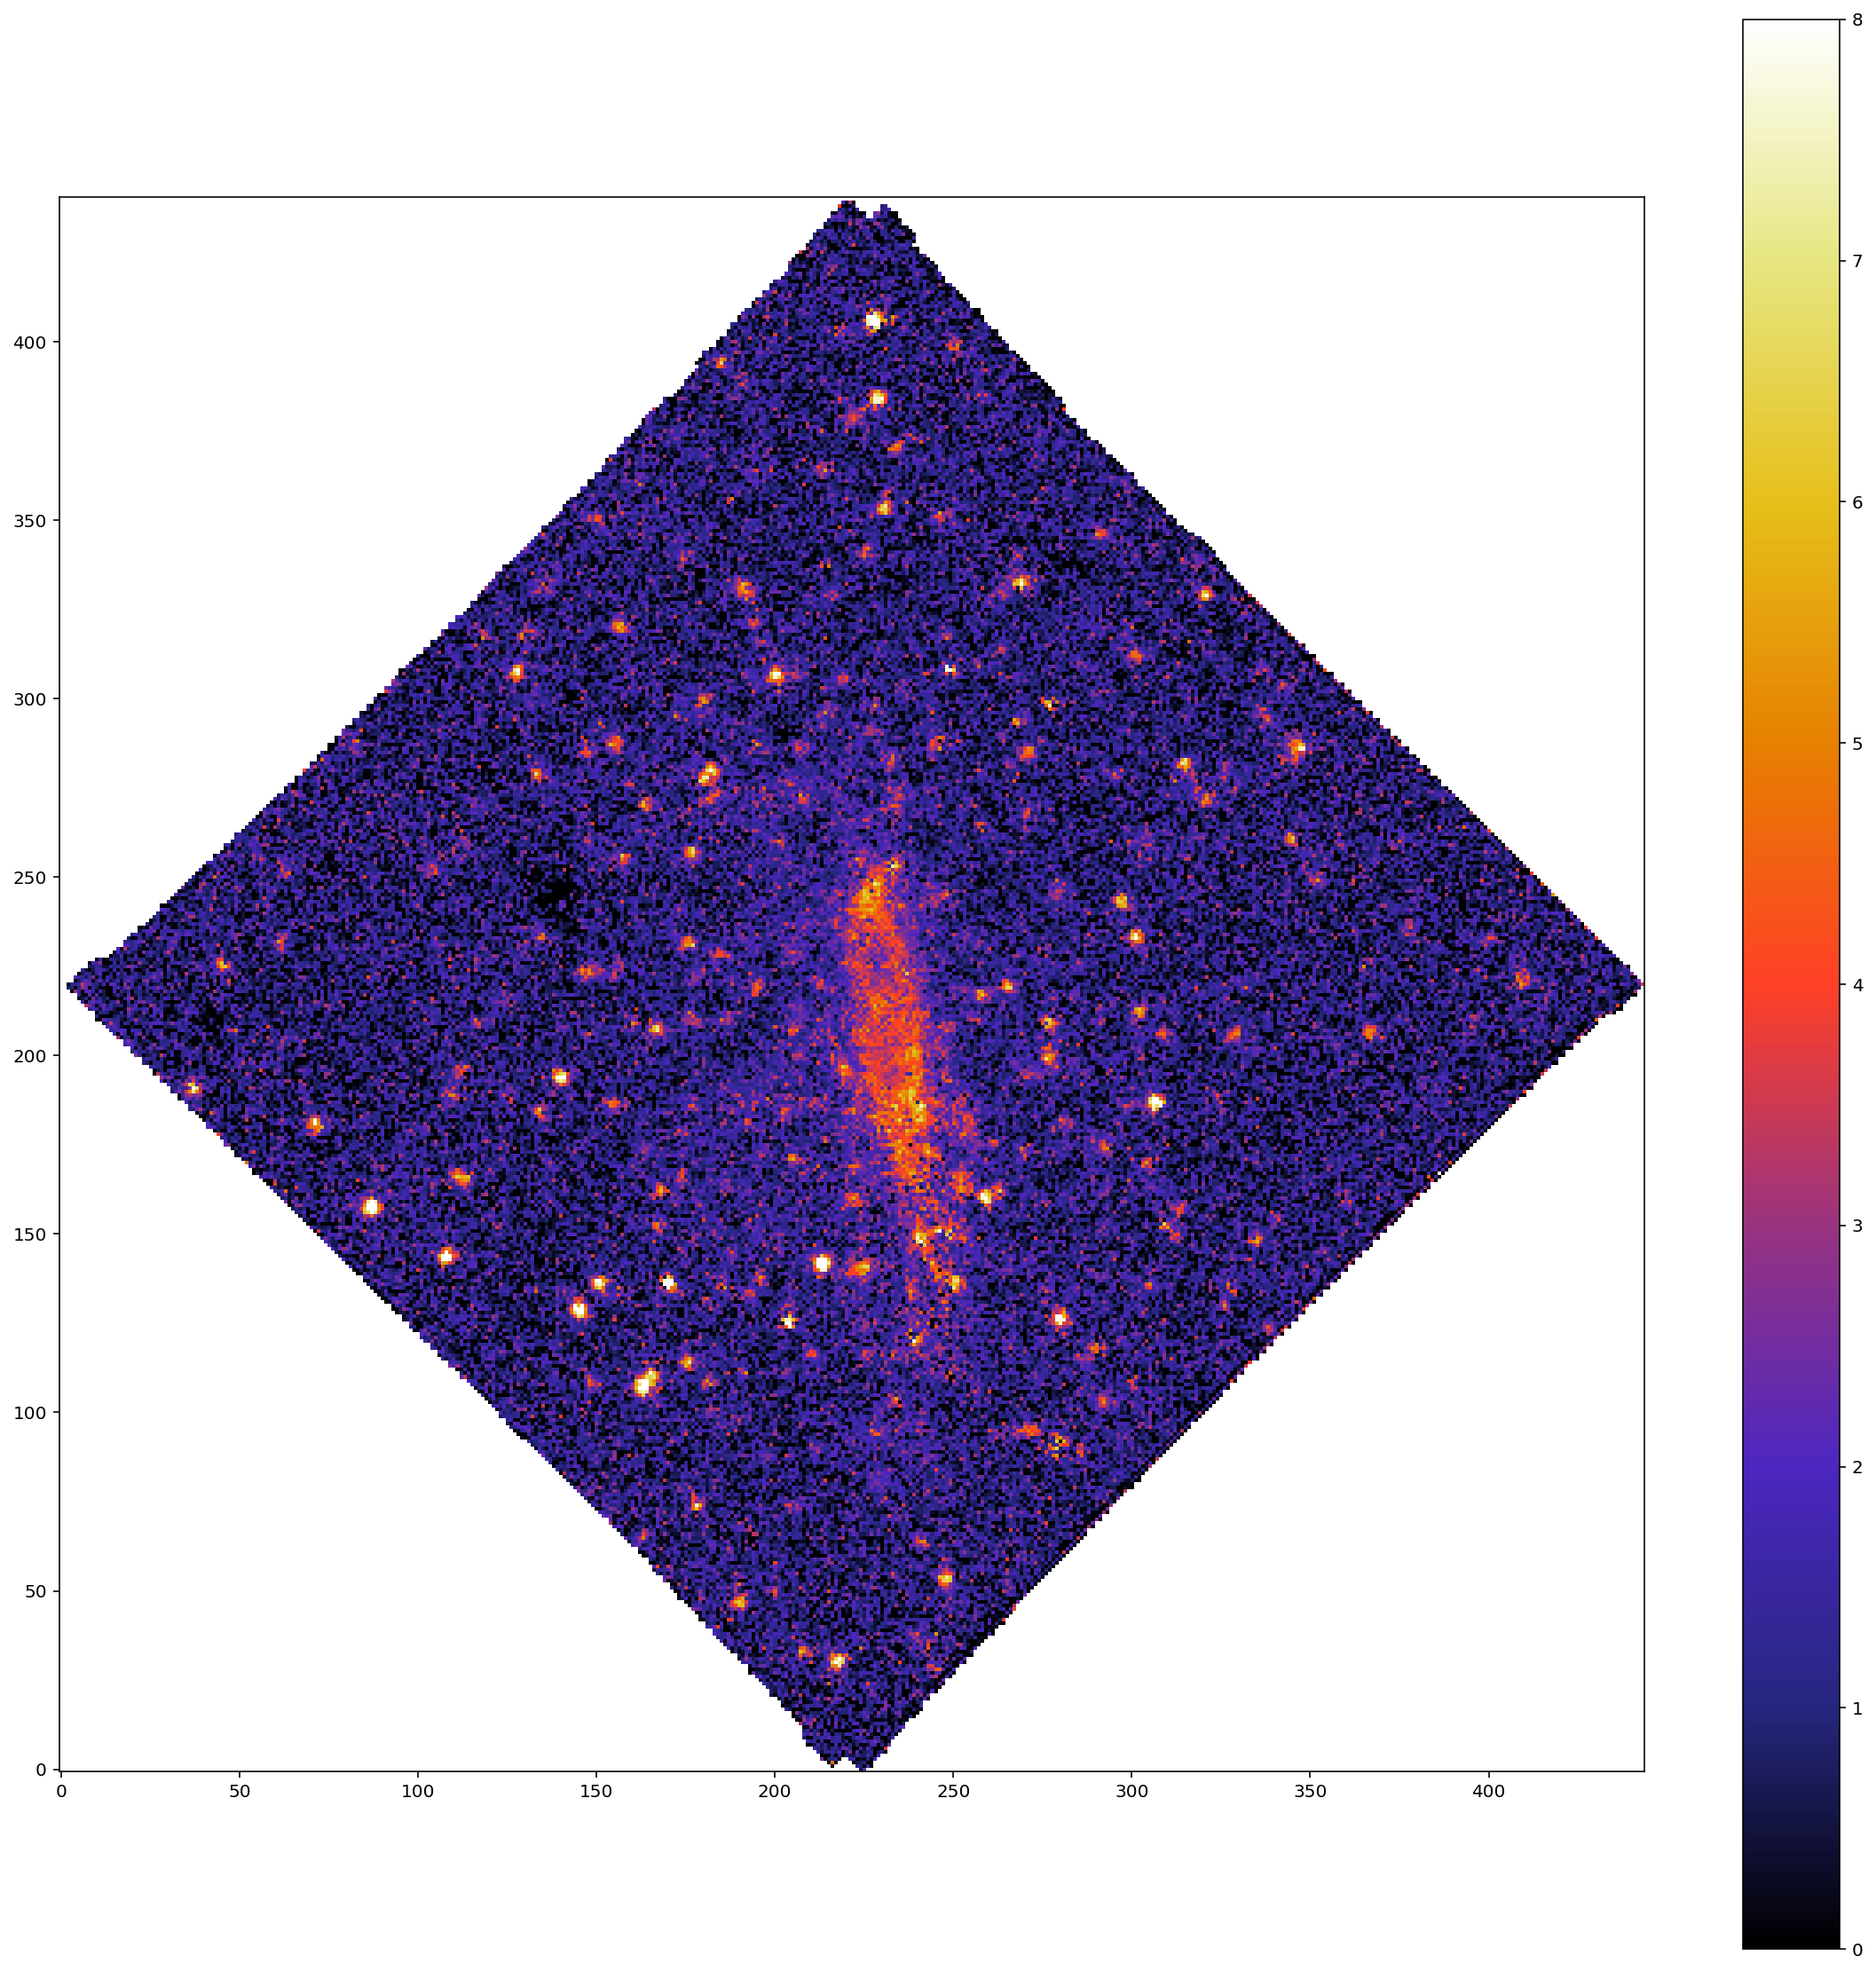

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(A_rN_shape, origin="lower", cmap="CMRmap", vmin=0, vmax=8)
plt.colorbar()

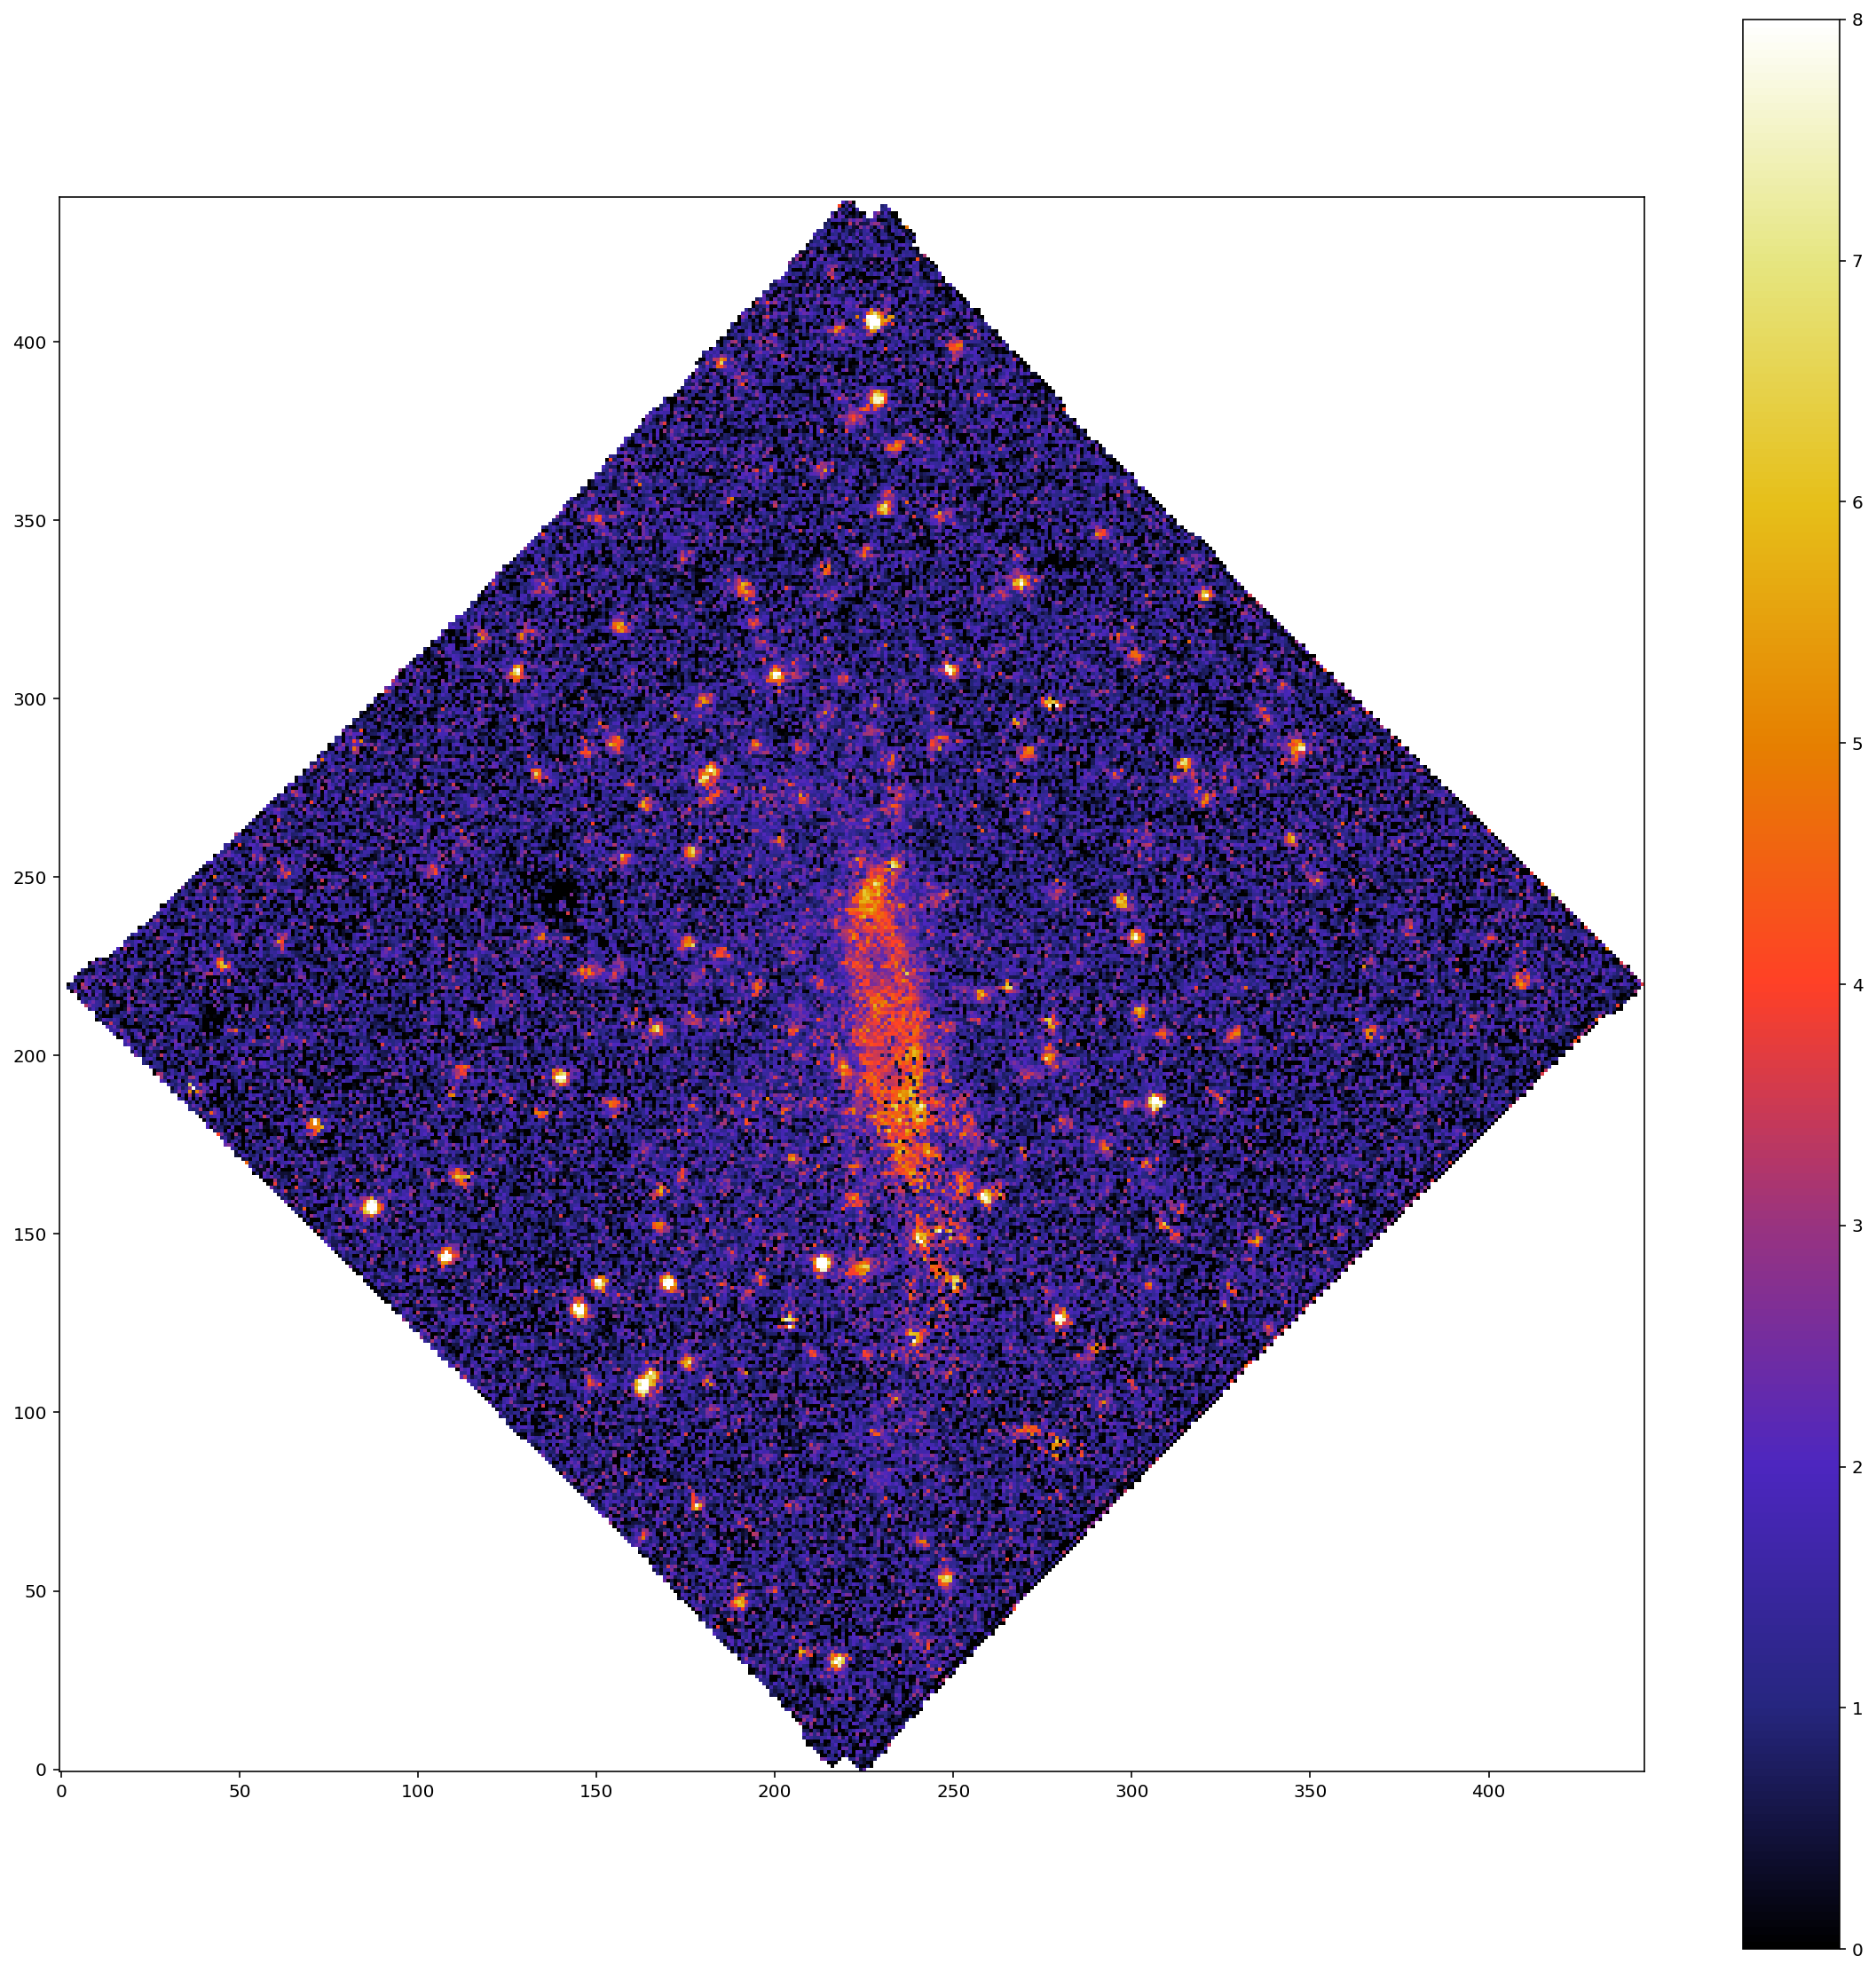

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(A_rN_shape, origin="lower", cmap="CMRmap", vmin=0, vmax=8)
plt.colorbar()

In [8]:
A_o_N_hdu = fits.open("FCC167_data/FCC167_AoN.fits")
A_o_N_data = A_o_N_hdu[0].data.byteswap().newbyteorder()
plt.figure(figsize=(20,20))
plt.imshow(A_o_N_data, origin="lower", cmap="CMRmap", vmin=1, vmax=10)
plt.colorbar()
#plt.savefig("Plots/FCC167/for_boris.png")

OSError: [Errno 12] Cannot allocate memory

5.257439719963635
76


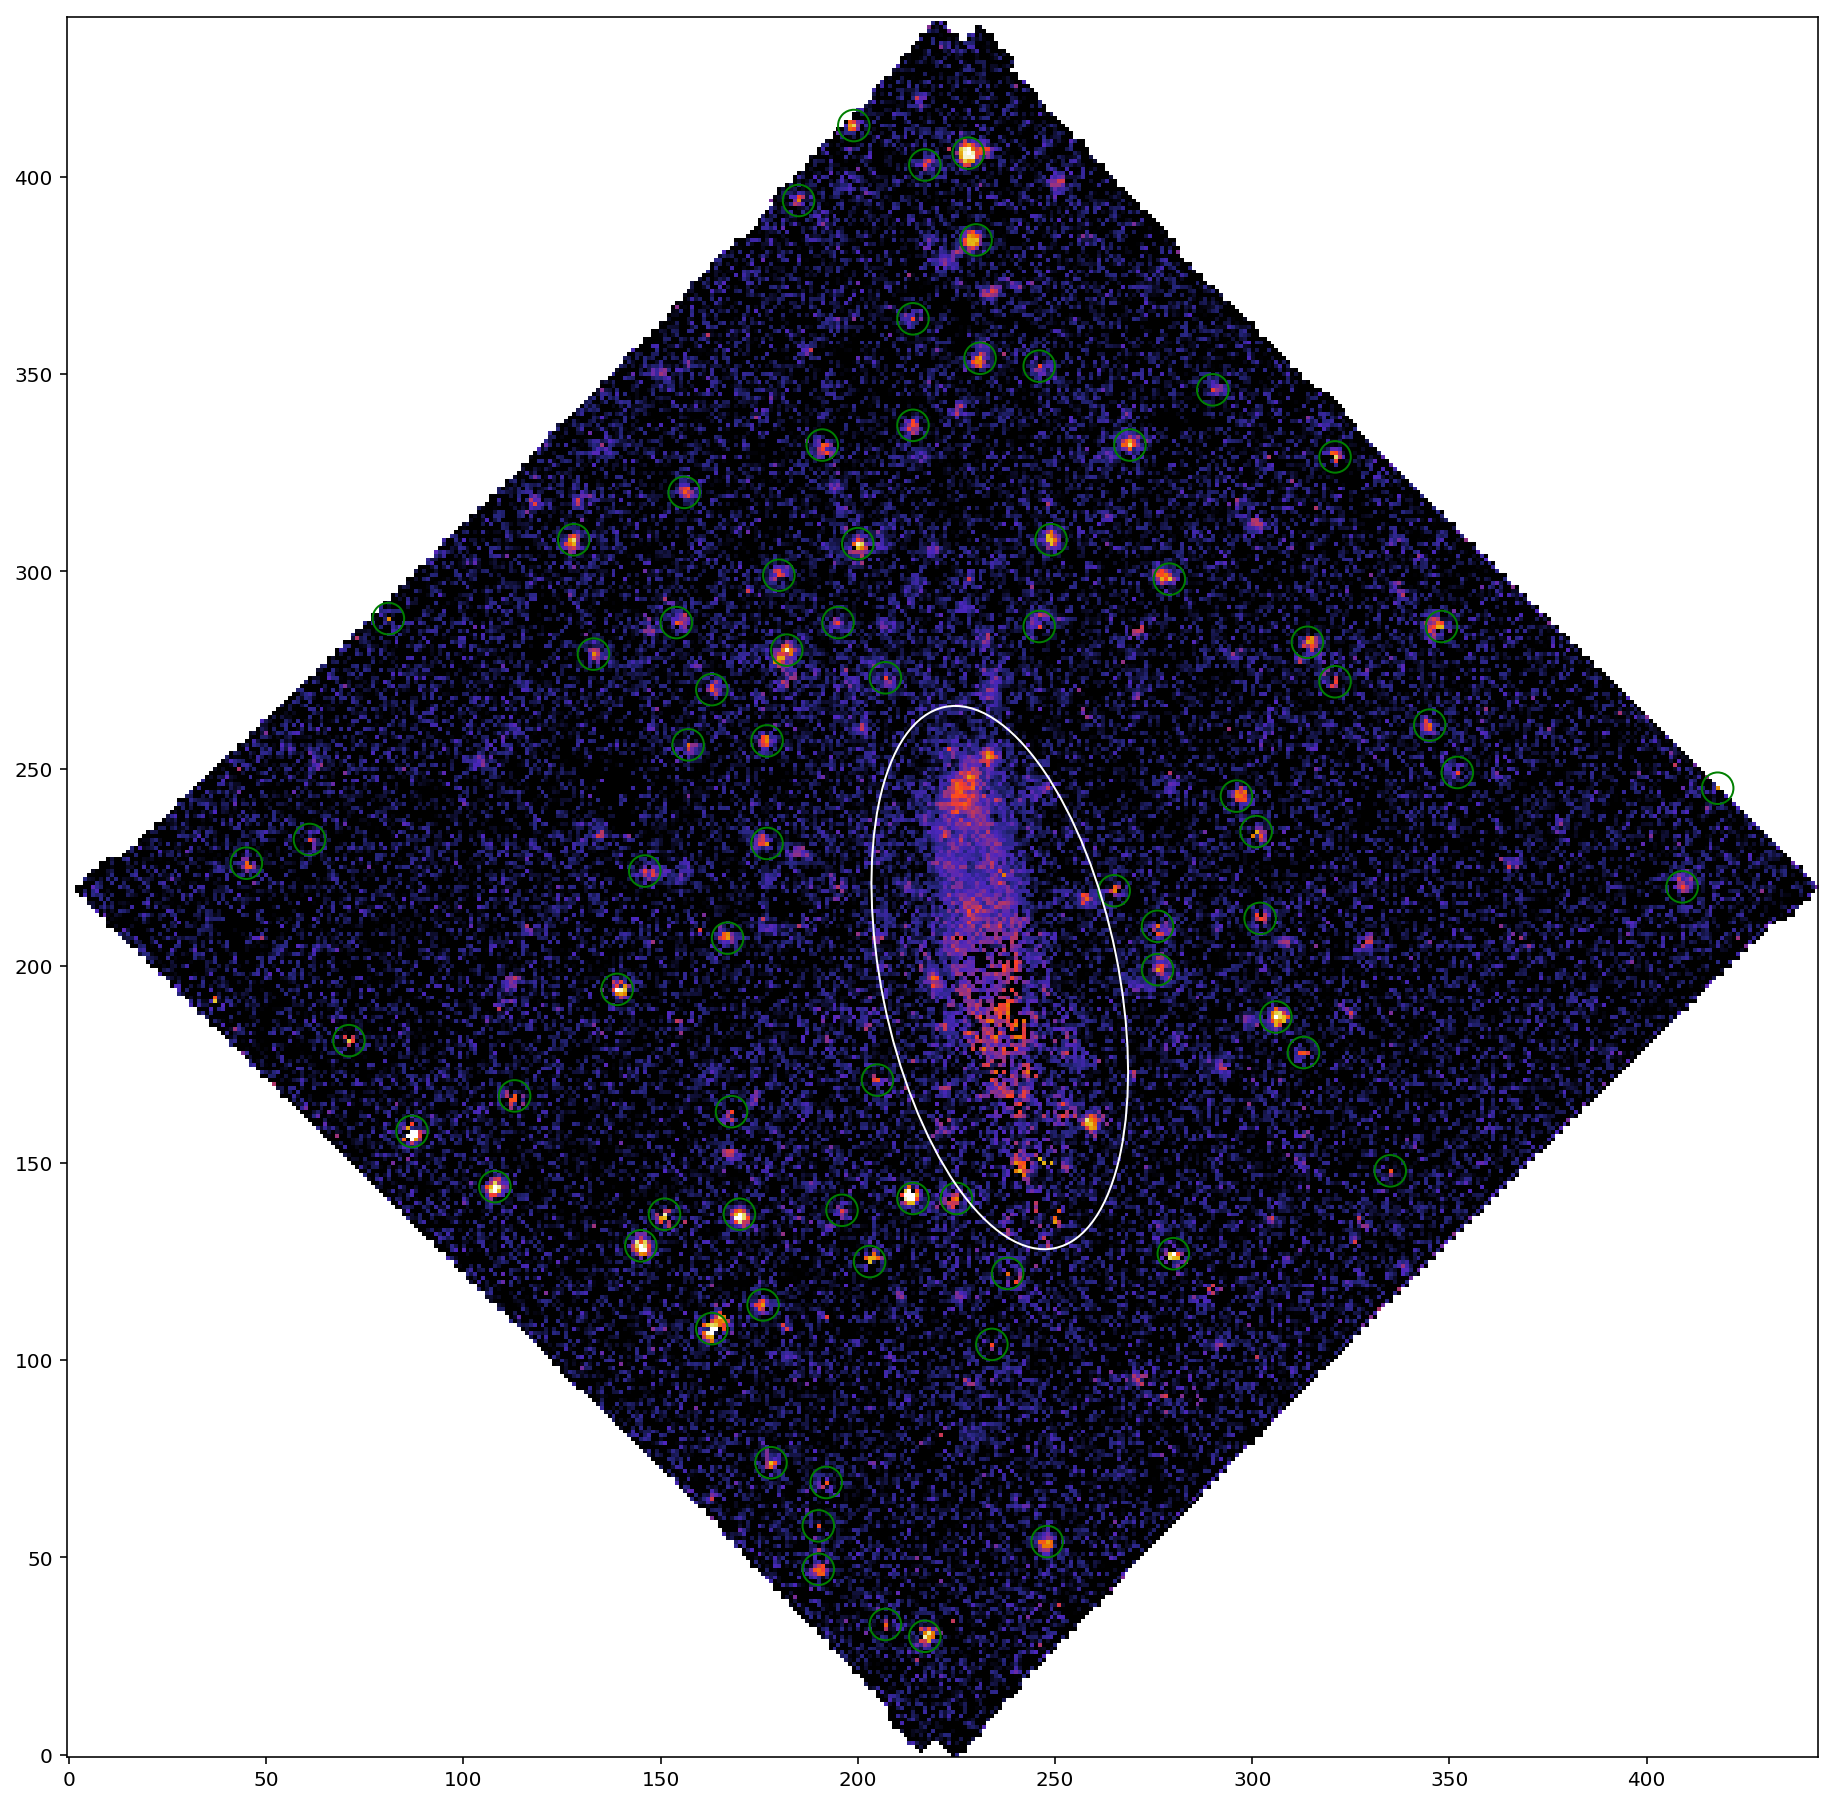

In [43]:
Y, X = np.mgrid[:y_data, :x_data]
xe = 236
ye = 197
length= 140
width = 60

alpha = 0.2
elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1
PNe_17_mask = (X-213)**2 + (Y-142)**2 <=4**2
#galaxy_elip_mask = np.load("exported_data/FCC167/mask.npy")
#objects = sep.extract(gauss_A.reshape(441, 444), 7., err=list_of_std.reshape(y_data, x_data), clean=False, mask=elip_mask)
mean, median, std = sigma_clipped_stats(A_rN_shape, sigma=3.0)
threshold = median + (5.*std)
print(threshold)
objects = find_peaks(A_rN_shape, threshold, box_size=8, mask=elip_mask_gal)
#sep.extract(gauss_A_shape, 25, clean=False, mask=elip_mask_gal, minarea=4.)#+PNe_17_mask)
x_phot = objects["x_peak"]
y_phot = objects["y_peak"]

#x_sep = objects["x"]
#y_sep = objects["y"]

positions = (x_phot, y_phot)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=10.)
apertures.plot(color="green")

ax = plt.gca()
elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white")
PNe_17 = Circle((213,142), fill=False, color="white")
#elip_extra = Ellipse((210,230), 20, 50, angle=alpha*(180/np.pi), fill=False, color="white")

ax.add_artist(elip_gal)
#ax.add_artist(PNe_17)

#ax.add_artist(circ)


sep_x_y_list = [[x,y] for x,y in zip(x_phot, y_phot)]

print(len(x_phot))
#np.save("exported_data/FCC167/sep_x_y_list", sep_x_y_list)

72


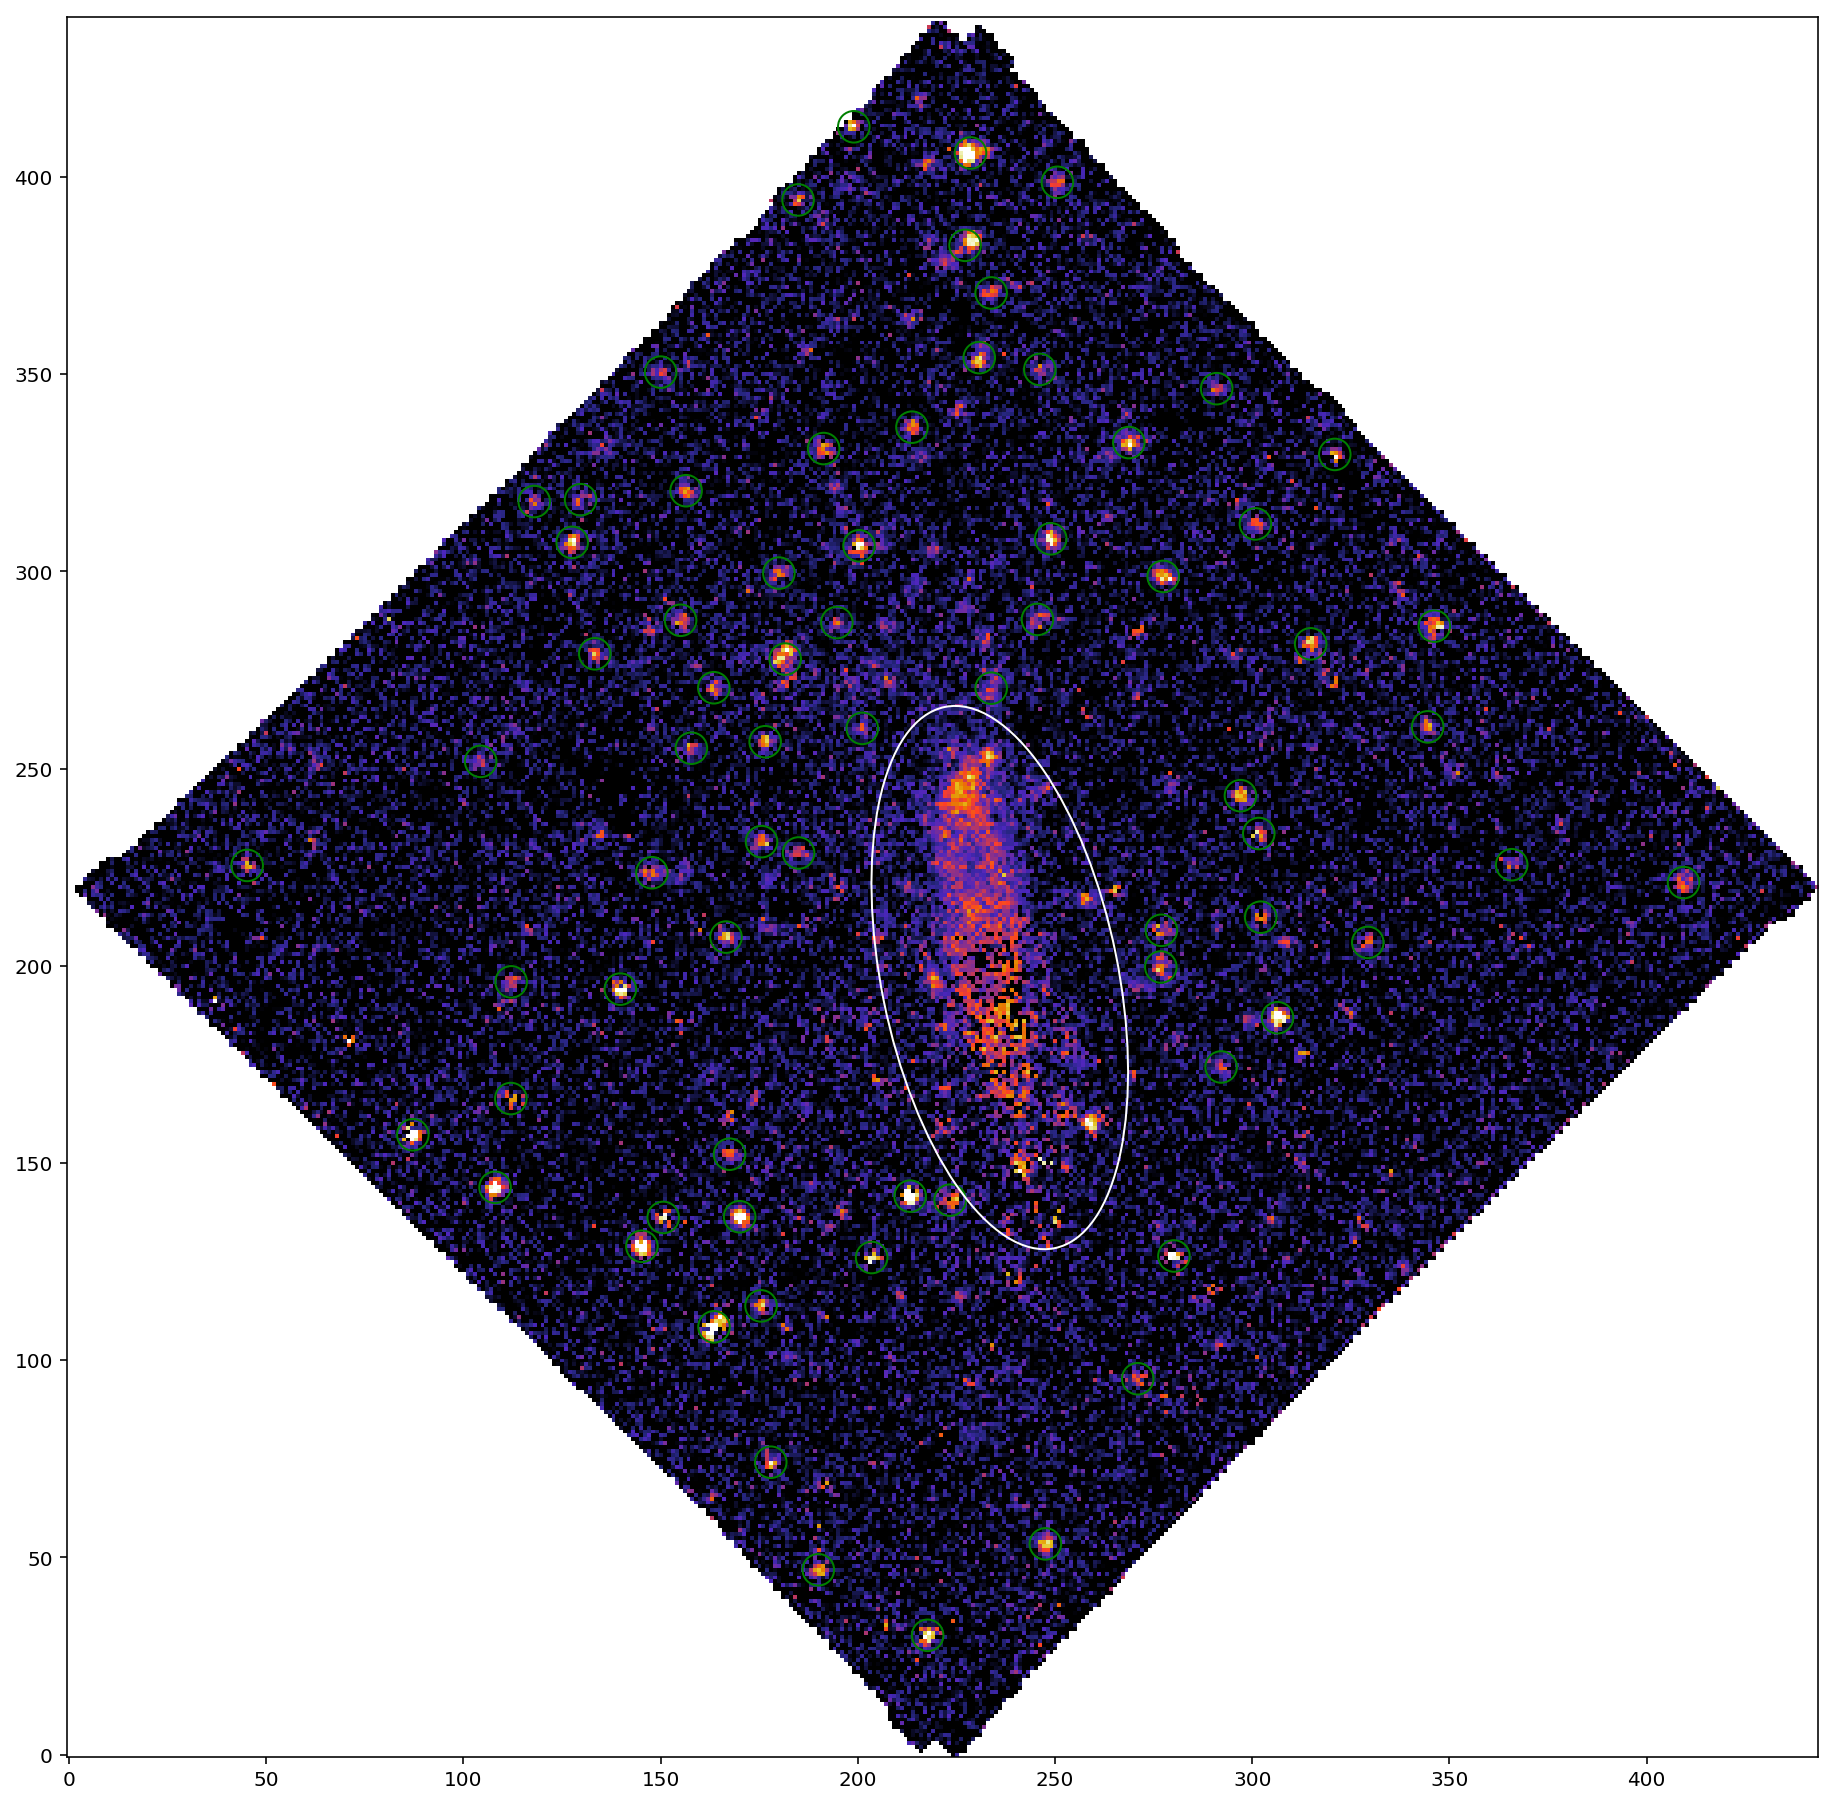

In [38]:
import sep
from photutils import CircularAperture

A_rN_shape[A_rN_shape == A_rN_shape[0,0]] = 0.0

Y, X = np.mgrid[:y_data, :x_data]
xe = 236
ye = 197
length= 140
width = 60

alpha = 0.2
elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1
PNe_17_mask = (X-213)**2 + (Y-142)**2 <=4**2
#galaxy_elip_mask = np.load("exported_data/FCC167/mask.npy")
#objects = sep.extract(gauss_A.reshape(441, 444), 7., err=list_of_std.reshape(y_data, x_data), clean=False, mask=elip_mask)
objects = sep.extract(A_rN_shape, 2.8, clean=True, mask=elip_mask_gal)#, err=np.array(np.abs(list_of_rN)).reshape(y_data,x_data))#+PNe_17_mask)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8.)
apertures.plot(color="green")

ax = plt.gca()
elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white")
PNe_17 = Circle((213,142), fill=False, color="white")
#elip_extra = Ellipse((210,230), 20, 50, angle=alpha*(180/np.pi), fill=False, color="white")

ax.add_artist(elip_gal)
#ax.add_artist(PNe_17)

#ax.add_artist(circ)


sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]

print(len(x_sep))
#np.save("exported_data/FCC167/sep_x_y_list", sep_x_y_list)

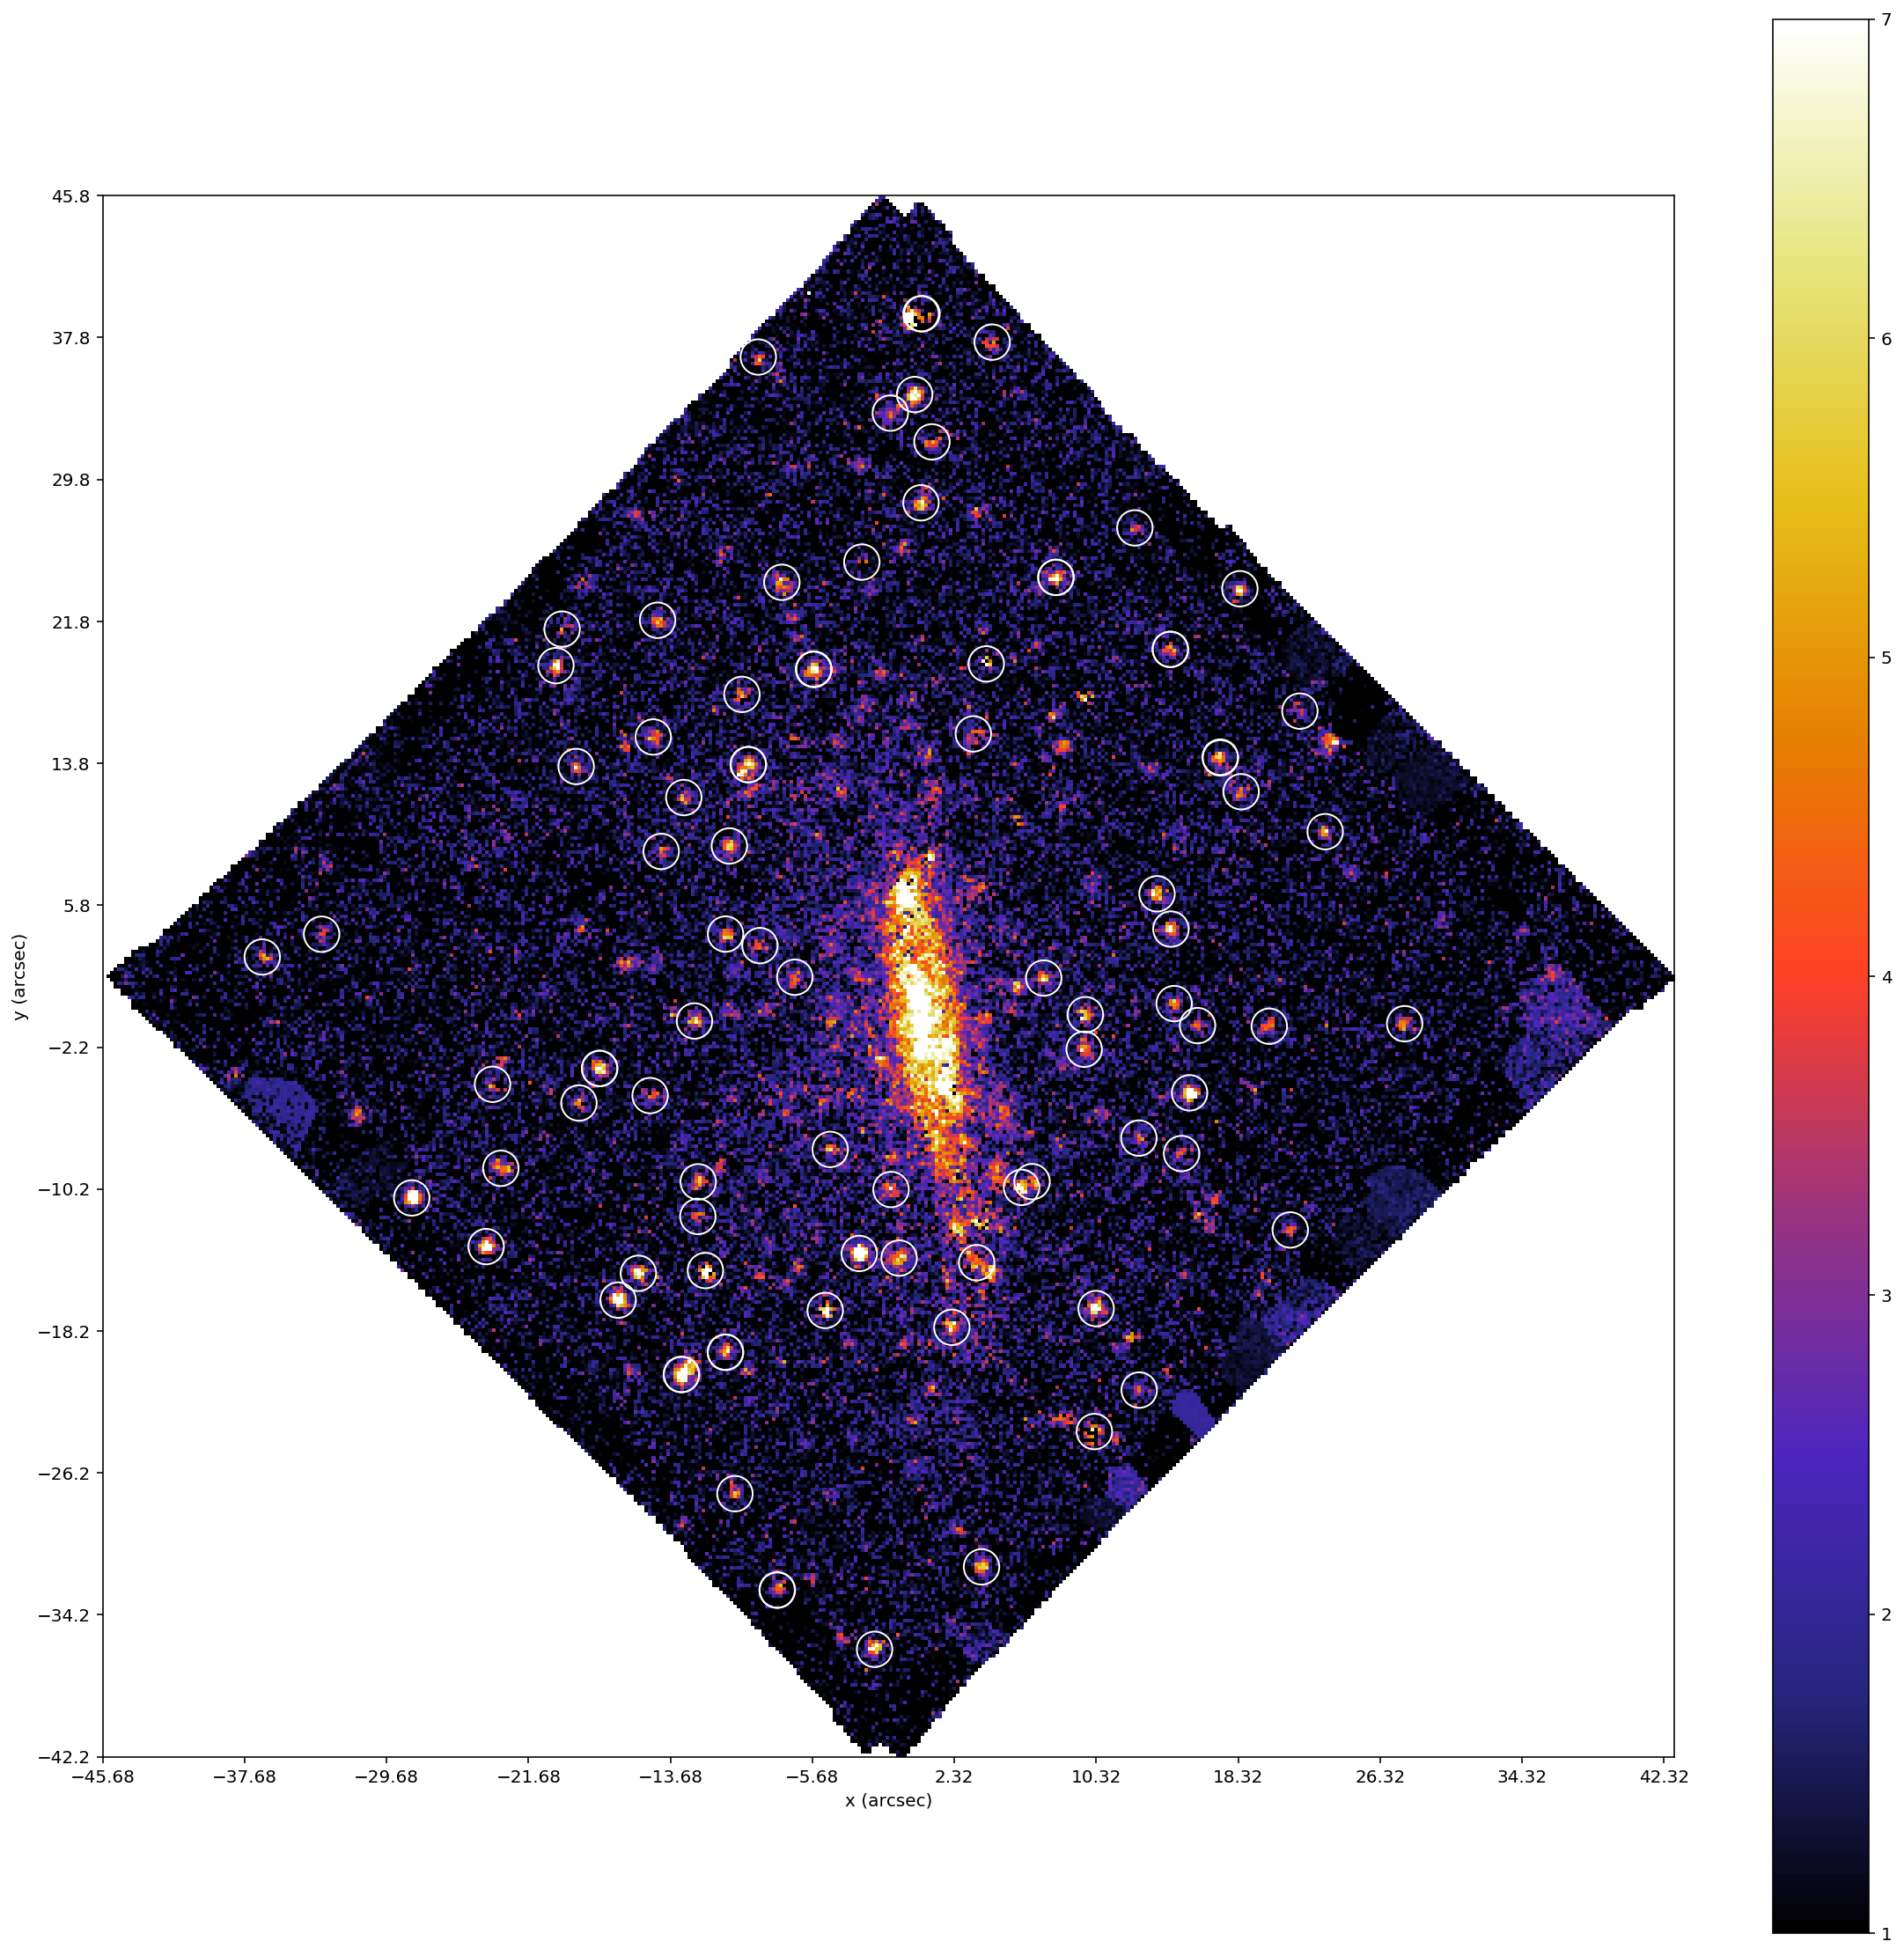

In [9]:
coords = ascii.read("FCC167_data/FCC167_xy_PNe_Marc_forThomas.txt", names=["x_PNe", "y_PNe"])
x_PNe = coords["x_PNe"]
y_PNe = coords["y_PNe"]
x_y_list = [x_PNe, y_PNe]

coords_arc = ascii.read("FCC167_data/FCC167_xy_forThomas.txt", names=["x","y"])
x_arc = coords_arc["x"][:444]
y_arc = coords_arc["y"][::444]

plt.figure(3,figsize=(20,20))
plt.imshow(A_rN_shape, extent = (x_arc[0], x_arc[-1], y_arc[0],y_arc[-1]), origin="lower", cmap="CMRmap", vmin=1, vmax=7)
plt.xticks(x_arc[::40])
plt.yticks(y_arc[::40])
cb = plt.colorbar()
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")

for x, y in zip(x_PNe,y_PNe):
    ax = plt.gca()
    circ = plt.Circle((x,y),1, color="white", fill=False)
    ax.add_artist(circ)
    plt.draw()
    
plt.savefig("Plots/FCC167_circled points.png")
#for i, item in enumerate(x_y_list):
#    ax = plt.gca()
#    circ = plt.Circle((item[0],item[1]),6, color="white", fill=False)
#    ax.add_artist(circ)
#    ax.annotate(i+1, (item[0]-8, item[1]-16), color="white", size=25)
#   plt.draw()